In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/cleaned.csv')

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df['Total_alc'] = list(map(lambda x: int(x), ((df['Total_alc'] ** 0.5).values)))

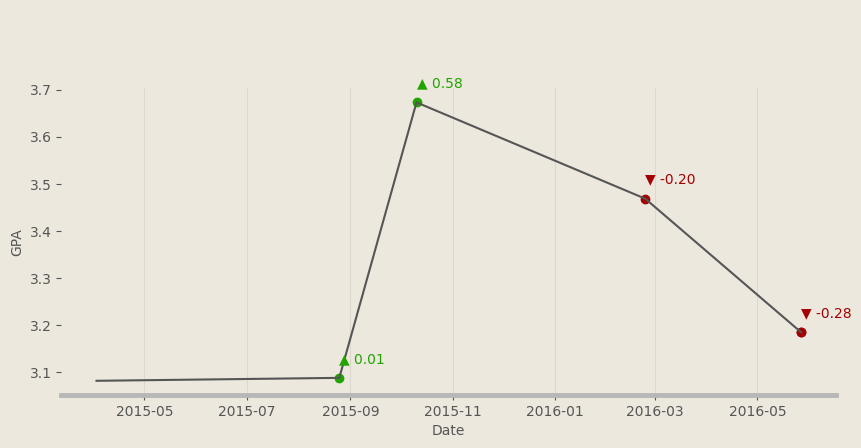

In [106]:
from sklearn.metrics import r2_score
import numpy as np
import matplotlib as mpl

class InsightExtractor():
	def __init__(self, data):
		self.data = data
		self.cols = ['failures', 'health', 'studytime', 'higher', 'goout', 'traveltime', 'activities', 'Total_alc']
		self.mins = {}
		self.grouped = {}
		self.maxs = {}
		for col in self.cols:
			self.grouped[col] = self.data[[col, 'GPA']].groupby(by=col).mean('GPA')
			self.mins[col] = self.grouped[col].min().values[0] * 0.95
			self.maxs[col] = self.grouped[col].max().values[0] * 1.05

		self.xticklabels = {
			'failures': [0, 1, '2', '3+'],
			'health': ['very bad', 'bad', 'ok', 'good', 'very good'],
			'studytime': ['1-2 hrs', '2-5 hrs', '5-10 hrs', '10+ hrs'],
			'higher': None,
			'goout': ['very little', 'little', 'normal', 'quite a bit', 'a lot'],
			'traveltime': ['<15 min', '15-30 min', '30min-1hr', '1+ hr'],
			'activities': None,
			'Total_alc': ['very little', 'little', 'normal', 'quite a bit', 'a lot']
		}

		self.xlabel = {
			'failures': 'Number of failures',
			'health': 'Health Status',
			'studytime': 'Studytime per week',
			'higher': 'Want to go to university?',
			'goout': 'How often do you go out?',
			'traveltime': 'Travel time to school',
			'activities': 'Extra-curricular activities?',
			'Total_alc': 'Drink a lot of alcohol?'
		}

		self.insights = {
			'failures': ['lower failures.', 'students with lower number of failures score higher.'],
			'health': ['maintain health.', 'students health stats has an effect on performance.'],
			'studytime': ['extra studying.', 'students that spend more time studying perform better.'],
			'higher': ['dream big.', 'students that aim for university attain better results.'],
			'goout': ['healthy breaks.', 'students that go out for a moderate and healthy amount have better performance.'],
			'traveltime': ['decrease travel time.', 'students that spend less time traveling score well.'],
			'activities': ['more extra-curriculars.', 'students that participate in curricular activities do better.'],
			'Total_alc': ['less drinking.', 'students that drink less have better scores.']
		}

	def produce_graph(self, col, chosen, color = '#888', resultid = None):
		COLOR = '#555'

		mpl.rcParams['text.color'] = COLOR
		mpl.rcParams['axes.labelcolor'] = COLOR
		mpl.rcParams['xtick.color'] = COLOR
		mpl.rcParams['ytick.color'] = COLOR

		fig = plt.figure(figsize=(10, 5))
		subplots = fig.subplots(2, 1, gridspec_kw = {'height_ratios':[1,7]})
		ax = subplots[1]
		subplots[0].axis('off')
		sns.barplot(self.data, x=col, y='GPA', ax = ax)

		ax.set_facecolor('#EAE4D6')
		fig.patch.set_facecolor('#EAE4D6')
		ax.grid(False)
		max_height = 0
		min_height = 1e9
		for i, patch in enumerate(ax.patches):
			ticks = list(map(lambda x: x.get_text(), ax.get_xticklabels()))
			if i == ticks.index(str(chosen)):
				patch.set_color(color)
			else:
				patch.set_color('#D9D9D9')

			max_height = max(max_height, patch.get_height())
			min_height = min(min_height, patch.get_height())

		diff = abs(max_height - min_height) * 2
		ax.set_ylim(min_height - diff, max_height + diff * 0.25)

		for i, line in enumerate(ax.lines):
			line.set_visible(False)

		ax.spines['top'].set_visible(False)
		ax.spines['right'].set_visible(False)
		ax.spines['left'].set_color('#B7B7B7')
		ax.spines['bottom'].set_color('#B7B7B7')

		ax.spines['left'].set(linewidth = 3.5)
		ax.spines['bottom'].set(linewidth = 3.5)

		if self.xticklabels[col]:
			ax.set_xticklabels(self.xticklabels[col])
		
		ax.set_xlabel(self.xlabel[col])
		return fig

	def extract(self, X):
		good_col = None
		good_score = -10
		improve_col = None
		improve_score = -10
		for col in self.cols:
			key = X[col].item()
			if type(key) == str and key.isnumeric():
				key = int(key)
			current = self.grouped[col].loc[key].item()
			potential_improve = abs(self.maxs[col] - current)
			potential_good = abs(self.mins[col] - current)

			if improve_score < potential_improve:
				improve_score = potential_improve
				improve_col = col

			if good_score < potential_good:
				good_score = potential_good
				good_col = col

		good_fig = self.produce_graph(good_col, X[good_col].item(), color = '#8A8')
		plt.close()
		improve_fig = self.produce_graph(improve_col, X[improve_col].item(), color = '#A88')
		plt.close()
		return self.insights[good_col], good_fig, self.insights[improve_col], improve_fig

	def history(self, history_df):
		COLOR = '#555'

		mpl.rcParams['text.color'] = COLOR
		mpl.rcParams['axes.labelcolor'] = COLOR
		mpl.rcParams['xtick.color'] = COLOR
		mpl.rcParams['ytick.color'] = COLOR

		fig = plt.figure(figsize=(10, 5))
		subplots = fig.subplots(2, 1, gridspec_kw = {'height_ratios':[1,7]})
		ax = subplots[1]
		subplots[0].axis('off')
		sns.lineplot(history_df, x='Date', y='GPA', ax = ax, color ='#555')

		ax.set_facecolor('#ECE8DE')
		fig.patch.set_facecolor('#ECE8DE')
		ax.grid(False, axis='y')
		ax.grid(True, axis='x', color='#DCD8CE')

		ax.spines['top'].set_visible(False)
		ax.spines['right'].set_visible(False)
		ax.spines['left'].set_visible(False)
		ax.spines['bottom'].set_color('#B7B7B7')

		ax.spines['bottom'].set(linewidth = 3.5)

		for i in range(1, len(history_df)):
			coords = [*history_df.sort_values(by='Date').iloc[i]][::-1]
			try:
				old_gpa = history_df.sort_values(by='Date')['GPA'].iloc[i - 1]
			except:
				old_gpa = history_df.sort_values(by='Date')['GPA'].iloc[i]

			new_gpa = history_df.sort_values(by='Date')['GPA'].iloc[i]
			color = '#21A300' if new_gpa >= old_gpa else '#A30002' 
			direction = "▲" if new_gpa >= old_gpa else "▼"

			ax.scatter(coords[0], coords[1], color = color)
			ax.text(
				coords[0],
				coords[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05,
				f'{direction} {new_gpa - old_gpa:.2f}',
				color = color
			)

		ax.scatter(*[*history_df.sort_values(by='Date').iloc[-1]][::-1], color = color)

		return fig

extractor = InsightExtractor(df)
def random_dates(start, end, n=10):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('2018-01-01')
random = random_dates(start, end)
history = pd.DataFrame({"GPA": np.random.random(len(random)) * 1 + np.arange(0, len(random) * 0.1, 0.1) + 2, 'Date': random.values})

extractor.history(history.tail(5))
plt.show()

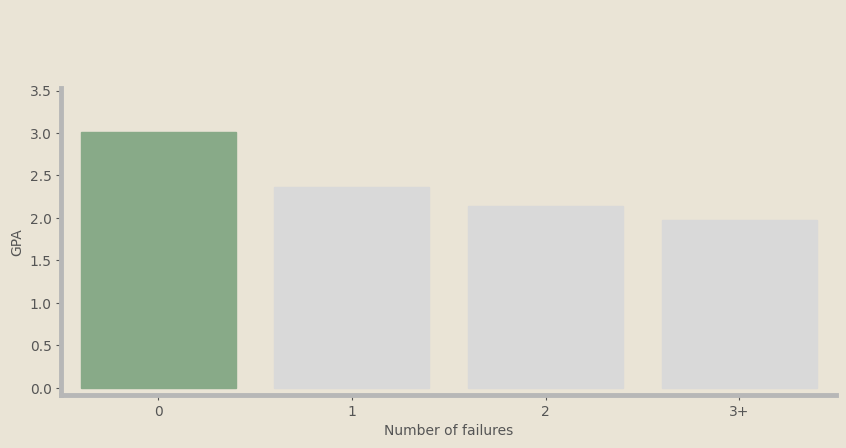

In [41]:
sampled = df.sample(1)
good_insights, good_fig, improve_insights, improve_fig = extractor.extract(sampled)
good_fig

In [42]:
import joblib
joblib.dump(extractor, 'weights/extractor.pkl')

['weights/extractor.pkl']